<a href="https://colab.research.google.com/github/SballarinAndre/Disciplina-Nexus/blob/main/analisesCABra_new_Map.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import gc
import cftime
import pathlib
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from functools import reduce
from scipy.optimize import curve_fit
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
!pip install --upgrade geopandas
!pip install --upgrade pyshp
!pip install --upgrade shapely
!pip install --upgrade descartes
from matplotlib.colors import DivergingNorm
import geopandas as gpd
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.colors import LinearSegmentedColormap

     |████████████████████████████████| 1.0 MB 20.7 MB/s 
     |████████████████████████████████| 6.3 MB 50.4 MB/s 
     |████████████████████████████████| 15.4 MB 39 kB/s 
     |████████████████████████████████| 219 kB 25.2 MB/s 
  Created wheel for pyshp: filename=pyshp-2.1.3-py3-none-any.whl size=37325 sha256=45f9ac4e10d2a56c2dedf932804dab9f71f33ae2f67da9532544c285485023c6
  Stored in directory: /root/.cache/pip/wheels/43/f8/87/53c8cd41545ba20e536ea29a8fcb5431b5f477ca50d5dffbbe
Successfully built pyshp


In [ ]:
# Finding CABRa attributes csv files
pathFiles = pathlib.Path('/content/drive/MyDrive/Colab Notebooks/CABRa_attributes_csv/')
cabraAttributesFiles = pathFiles.rglob('*.csv')


In [ ]:
# Reading files
dfs = []
for file in cabraAttributesFiles:
    print(file)
    df = pd.read_csv(file, engine='python', delimiter=',')
    dfs.append(df)

/content/drive/MyDrive/Colab Notebooks/CABRa_attributes_csv/CABra_dataset _Additional_attributes.csv
/content/drive/MyDrive/Colab Notebooks/CABRa_attributes_csv/CABra_dataset _Climate_attributes.csv
/content/drive/MyDrive/Colab Notebooks/CABRa_attributes_csv/CABra_dataset_Groundwater_attributes.csv
/content/drive/MyDrive/Colab Notebooks/CABRa_attributes_csv/CABra_dataset_Hydrologic_disturbance_attributes.csv
/content/drive/MyDrive/Colab Notebooks/CABRa_attributes_csv/CABra_dataset_Land_cover_attributes.csv
/content/drive/MyDrive/Colab Notebooks/CABRa_attributes_csv/cabra_general_attributes.csv
/content/drive/MyDrive/Colab Notebooks/CABRa_attributes_csv/cabra_Geology_attributes.csv
/content/drive/MyDrive/Colab Notebooks/CABRa_attributes_csv/CABra_soil_attributes.csv
/content/drive/MyDrive/Colab Notebooks/CABRa_attributes_csv/CABra_topography_attributes.csv
/content/drive/MyDrive/Colab Notebooks/CABRa_attributes_csv/CABra_dataset_Streamflow_attributes.csv


In [ ]:
# Merging DataFrames
dfMerged = reduce(lambda  left,right: pd.merge(left, right, on=['CABra ID', 'ANA ID'], how='outer'), dfs)

In [ ]:
dfMerged.columns

Index(['CABra ID', 'ANA ID', 'longitude_centroid', 'latitude_centroid',
       'dist_coast', 'clim_p', 'clim_tmin', 'clim_tmax', 'clim_rh',
       'clim_wind', 'clim_srad', 'clim_et', 'clim_pet', 'aridity_index',
       'p_seasonality', 'clim_quality', 'aquif_name', 'aquif_type',
       'catch_wtd', 'catch_hand', 'hand_class', 'dist_urban', 'cover_urban_x',
       'cover_crops_x', 'res_number', 'res_area', 'res_volume',
       'res_regulation', 'water_demand', 'hdisturb_index', 'cover_main',
       'cover_bare', 'cover_forest', 'cover_crops_y', 'cover_grass',
       'cover_moss', 'cover_shrub', 'cover_urban_y', 'cover_snow',
       'cover_waterp', 'cover_waters', 'ndvi_djf', 'ndvi_mam', 'ndvi_jja',
       'ndvi_son', 'longitude', 'latitude', 'gauge_hreg', 'gauge_biome',
       'gauge_state', 'missing_data', 'series_length', 'quality_index',
       'catch_lith', 'sub_porosity', 'sub_permeability', 'sub_hconduc',
       'soil_type', 'soil_textclass', 'soil_sand', 'soil_silt', 'soil_clay'

In [ ]:
#Values for annual time-scale
dfMerged['clim_p_annual'] = dfMerged['clim_p']*365.26667
dfMerged['clim_pet_annual'] = dfMerged['clim_pet']*365.26667

In [ ]:
# Calculating ECI (Liu et al. (2020))
# Calculating the ratio Effective Area / Topographic Area (Liu et al. (2020))
dfMerged['ECI'] = np.log10(dfMerged['q_mean']/(dfMerged['clim_p']-dfMerged['clim_et']))
dfMerged['Aeff/Atopo'] = dfMerged['q_mean']/(dfMerged['clim_p']-dfMerged['clim_et'])

/usr/local/lib/python3.7/dist-packages/pandas/core/series.py:726: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [ ]:
# Creating new column called 'substantial' and grouping into 3 groups
# The ratio is according to Liu et al. (2020)
max_ratio = 2
min_ratio = 0.5

dfMerged.loc[dfMerged['Aeff/Atopo']>=max_ratio, 'substantial'] = 'Gaining'
dfMerged.loc[(dfMerged['Aeff/Atopo']<max_ratio)&
              (dfMerged['Aeff/Atopo']>1), 'substantial'] = 'Small gain'
dfMerged.loc[(dfMerged['Aeff/Atopo']>min_ratio)&
              (dfMerged['Aeff/Atopo']<=1), 'substantial'] = 'Small loss'
dfMerged.loc[dfMerged['Aeff/Atopo']<=min_ratio, 'substantial'] = 'Losing'



In [ ]:
#Correcting values of Q according to Aeff/Atopo
dfMerged['q_quickflow_annual_corrected'] = dfMerged['q_quickflow_annual']/dfMerged['Aeff/Atopo']
dfMerged['q_baseflow_annual_corrected'] = dfMerged['q_baseflow_annual']/dfMerged['Aeff/Atopo']
dfMerged['q_annual_corrected'] = dfMerged['q_annual']/dfMerged['Aeff/Atopo']

In [ ]:
#Filtering catchments - Excluding catchments with runoff coeficient > 1 and/or null values of ECI
dfFinal = dfMerged[dfMerged['runoff_coef'] < 1]
dfFinal = dfFinal[dfFinal['ECI'].notnull()]

In [ ]:
dfFinal.describe()

In [ ]:
#Defining BIAS of estimated Qb, Qd, Q and W
D = 0.38
def funcD_teste(x,a,b):
    return (np.exp(-(x**a) + np.sign(np.log(D))*np.float_power(abs(np.log(D)),(1.0/b))))**b

def funcB_teste(x,c,d):
    return (np.exp(-(x**c) + np.sign(np.log(1-D))*np.float_power(abs(np.log(1-D)),(1.0/d))))**d
def funcR_teste(x,a,b,c,d):
    return ((np.exp(-(x**a) + np.sign(np.log(D))*np.float_power(abs(np.log(D)),(1.0/b))))**b + (np.exp(-(x**c) + np.sign(np.log(1-D))*np.float_power(abs(np.log(1-D)),(1.0/d))))**d)


In [ ]:

par_aFinal= 1.08816485819687
par_bFinal= 1.23095186755981
par_cFinal= 1.19865250119228
par_dFinal= 0.735063074344181

x = dfFinal['aridity_index']
p = dfFinal['clim_p_annual']
qB = dfFinal['q_baseflow_annual']
qD = dfFinal['q_quickflow_annual']
qQ  = dfFinal['q_annual']
w  = dfFinal['clim_p_annual'] - dfFinal['q_quickflow_annual']

yD_est = funcD_teste(x,par_aFinal, par_bFinal)
yB_est = funcB_teste(x,par_cFinal, par_dFinal)
yQ_est = funcR_teste(x,par_aFinal, par_bFinal, par_cFinal, par_dFinal)
qB_est = yB_est*p
qD_est = yD_est*p
qQ_est = yQ_est*p
w_est  = p - qD_est

dfFinal['q_baseflow_bias'] = ((qB_est - qB)/qB)*100
dfFinal['q_quickflow_bias'] = ((qD_est - qD)/qD)*100
dfFinal['q_bias'] = ((qQ_est - qQ)/qQ)*100
dfFinal['w_bias'] = ((w_est - w)/w)*100
dfFinal['q_baseflow_annual_est'] = qB_est
dfFinal['q_quickflow_annual_est'] = qD_est
dfFinal['q_annual_est'] = qQ_est
dfFinal['w_annual_est'] = w_est

par_aFinal_corr= 0.72099025727739
par_bFinal_corr= 1.30100172735143
par_cFinal_corr= 0.752050524211796
par_dFinal_corr= 0.810305052137073

x = dfFinal['aridity_index']
p = dfFinal['clim_p_annual']
qB_cor = dfFinal['q_baseflow_annual_corrected']
qD_cor = dfFinal['q_quickflow_annual_corrected']
qQ_cor = dfFinal['q_annual_corrected']
w_cor  = dfFinal['clim_p_annual'] - dfFinal['q_quickflow_annual_corrected']

yD_est_cor = funcD_teste(x,par_aFinal_corr, par_bFinal_corr)
yB_est_cor = funcB_teste(x,par_cFinal_corr, par_dFinal_corr)
yQ_est_cor = funcR_teste(x,par_aFinal_corr, par_bFinal_corr, par_cFinal_corr, par_dFinal_corr)
qB_est_cor = yB_est_cor*p
qD_est_cor = yD_est_cor*p
qQ_est_cor = yQ_est_cor*p
w_est_cor  = p - qD_est_cor

dfFinal['q_baseflow_bias_corrected'] = ((qB_est_cor - qB_cor)/qB_cor)*100
dfFinal['q_quickflow_bias_corrected'] = ((qD_est_cor - qD_cor)/qD_cor)*100
dfFinal['q_bias_corrected'] = ((qQ_est_cor - qQ_cor)/qQ_cor)*100
dfFinal['w_bias_corrected'] = ((w_est_cor - w_cor)/w_cor)*100
dfFinal['q_baseflow_annual_est_cor'] = qB_est_cor
dfFinal['q_quickflow_annual_est_cor'] = qD_est_cor
dfFinal['q_annual_est_cor'] = qQ_est_cor
dfFinal['w_annual_est_cor'] = w_est_cor

# dfFinal['difBias_qb'] = dfFinal['q_baseflow_bias'].abs() - dfFinal['q_baseflow_bias_corrected'].abs()
# dfFinal['difBias_qd'] = dfFinal['q_quickflow_bias'].abs() - dfFinal['q_quickflow_bias_corrected'].abs()
# dfFinal['difBias_q'] = dfFinal['q_bias'].abs() - dfFinal['q_bias_corrected'].abs()
# dfFinal['difBias_w'] = dfFinal['w_bias'].abs() - dfFinal['w_bias_corrected'].abs()


# dfVazoes = dfFinal[['q_baseflow_annual','q_baseflow_annual_est', 'q_baseflow_annual_corrected','q_baseflow_annual_est_cor']]
# dfVazoes['bias_qb'] = abs(dfVazoes['q_baseflow_annual'] - dfVazoes['q_baseflow_annual_est'])
# dfVazoes['bias_qb_est'] = abs(dfVazoes['q_baseflow_annual_corrected'] - dfVazoes['q_baseflow_annual_est_cor'])
# dfVazoes.describe()

In [ ]:
dfFinal['qB_bias_fraction_abs'] = abs(dfFinal['q_baseflow_bias']/dfFinal['q_baseflow_bias_corrected'])
dfFinal['qD_bias_fraction_abs'] = abs(dfFinal['q_quickflow_bias']/dfFinal['q_quickflow_bias_corrected'])
dfFinal['qQ_bias_fraction_abs'] = abs(dfFinal['q_bias']/dfFinal['q_bias_corrected'])
dfFinal['w_bias_fraction_abs'] = abs(dfFinal['w_bias']/dfFinal['w_bias_corrected'])

In [ ]:
dfCorr = dfVazoes[['q_baseflow_bias_corrected','q_quickflow_bias_corrected','q_bias_corrected','w_bias_corrected']]
dfCorr.columns = ['Qb','Qd','Q','W']
dfSem  = dfFinal[['q_baseflow_bias','q_quickflow_bias','q_bias','w_bias']]
dfSem.columns = ['Qb','Qd','Q','W']

dfCorr = dfCorr.assign(Type = 'Aeff-Corrected')
dfSem = dfSem.assign(Type = 'No Correction')

cdf =  pd.concat([dfCorr,dfSem])
mdf = pd.melt(cdf, id_vars = 'Type')

pal = ['navy','brown']
fig,axes = plt.subplots( figsize = (8,4.5))
ax = sns.boxplot( y = "value", x = 'variable', palette = pal,
                     hue = "Type", data = mdf, 
                     width = 0.6, showmeans=True,
                     # boxprops =  dict(linestyle='-', linewidth=0.8, edgecolor = 'black'),
                     # medianprops = dict(linestyle='-.', linewidth=1, color='black'),
                    
                        meanprops={"markerfacecolor":"lightgray", "markeredgecolor":"black"})

plt.ylim([-100,500])
plt.legend(facecolor = 'lightgray', fontsize = 11)
plt.ylabel('Bias (%)', fontsize = 12)
plt.xlabel('')
plt.yticks(fontsize = 12)
plt.xticks(fontsize = 12)
ax.yaxis.grid(True, linestyle='-.', which='major', color='grey', alpha=0.5)

fig.savefig('/content/drive/MyDrive/Colab Notebooks/CABra_Figures/Box_Bias.jpeg', dpi=500)

In [ ]:
#Plotting Brazil map

BraEstados = gpd.read_file(r'/content/drive/MyDrive/Colab Notebooks/shape/Brasil-estados.shp')
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
SouthAmerica = world[world.continent == 'South America']

In [ ]:
bacias = gpd.GeoDataFrame(dfFinal, geometry=gpd.points_from_xy(dfFinal.longitude_centroid, dfFinal.latitude_centroid))

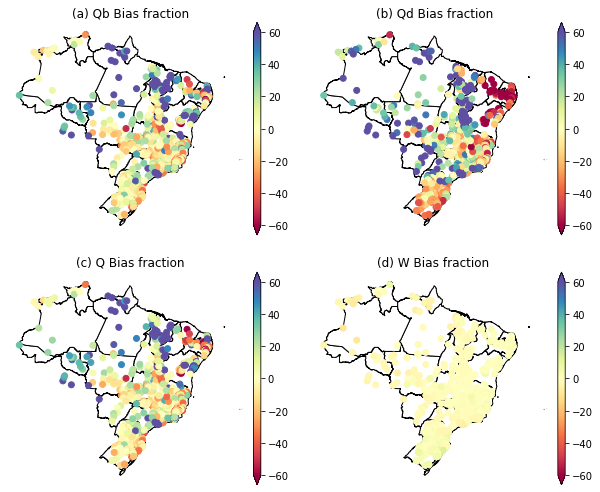

In [ ]:
fig, ax = plt.subplots(ncols = 2, nrows = 2, figsize = (10,10), sharex=True, sharey= True)

# SouthAmerica.plot(color = 'lightgray', edgecolor = 'black', ax = ax)

divider0 = make_axes_locatable(ax[0,0])
cax0 = divider0.append_axes("right", size="3%", pad=0)
BraEstados.plot(color = 'white', edgecolor = 'black', ax = ax[0,0])
bacias.plot(column = 'q_baseflow_bias', ax = ax[0,0],cmap = 'Spectral',
            legend = True,vmin = -60, vmax = 60, cax=cax0,
                        legend_kwds={'extend': 'both'})
ax[0,0].set_title('(a) Qb Bias fraction', fontsize = 12)
ax[0,0].set_axis_off()


divider1 = make_axes_locatable(ax[0,1])
cax1 = divider1.append_axes("right", size="3%", pad=0)
BraEstados.plot(color = 'white', edgecolor = 'black', ax = ax[0,1])
bacias.plot(column = 'q_quickflow_bias', ax = ax[0,1], cmap = 'Spectral',
            legend = True, vmin = -60, vmax = 60, cax=cax1,
                        legend_kwds={'extend': 'both'})
ax[0,1].set_title('(b) Qd Bias fraction', fontsize = 12)
ax[0,1].set_axis_off()

divider2 = make_axes_locatable(ax[1,0])
cax2 = divider2.append_axes("right", size="3%", pad=0)
BraEstados.plot(color = 'white', edgecolor = 'black', ax = ax[1,0])
bacias.plot(column = 'q_bias', ax = ax[1,0], cmap = 'Spectral',
            legend = True, vmin = -60, vmax = 60, cax=cax2,
                        legend_kwds={'extend': 'both'})
ax[1,0].set_title('(c) Q Bias fraction', fontsize = 12)
ax[1,0].set_axis_off()

divider3 = make_axes_locatable(ax[1,1])
cax3 = divider3.append_axes("right", size="3%", pad=0)
BraEstados.plot(color = 'white', edgecolor = 'black', ax = ax[1,1])
bacias.plot(column = 'w_bias', ax = ax[1,1], cmap = 'Spectral',
            legend = True, vmin = -60, vmax = 60, cax=cax3,
            legend_kwds={'extend': 'both'})
ax[1,1].set_title('(d) W Bias fraction ', fontsize = 12)
ax[1,1].set_axis_off()

fig.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=None, hspace=-0.15)
fig.savefig('/content/drive/MyDrive/Colab Notebooks/CABra_Figures/Brazil_bias_centroid.jpeg', dpi=500)


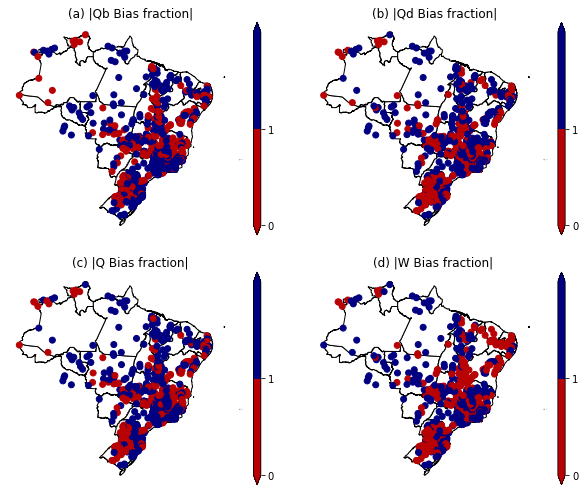

In [ ]:
fig, ax = plt.subplots(ncols = 2, nrows = 2, figsize = (10,10), sharex=True, sharey= True)

# SouthAmerica.plot(color = 'lightgray', edgecolor = 'black', ax = ax)

azul_escuro = '#0906E2'
azul_claro = '#818BC2'
vermelho_escuro = '#B80203'
vermelho_claro = '#F0C6C9'

vMin = 0
vMax = 20
ticks = [0,1]


# cmap = mpl.colors.ListedColormap([vermelho_escuro,vermelho_claro,azul_claro,'navy'])
cmap = mpl.colors.ListedColormap([vermelho_escuro,'navy'])

# bounds = [-20, -1, 0, 1, 20]
bounds = [0,1,20]
norm = mpl.colors.BoundaryNorm(bounds, cmap.N)


divider0 = make_axes_locatable(ax[0,0])
cax0 = divider0.append_axes("right", size="3%", pad=0)
BraEstados.plot(color = 'white', edgecolor = 'black', ax = ax[0,0])
bacias.plot(column = 'qB_bias_fraction_abs', ax = ax[0,0],cmap = cmap, norm = norm,
            legend = True,vmin = vMin, vmax = vMax, cax=cax0,
            legend_kwds={'ticks': ticks, 'extend': 'both'})
ax[0,0].set_title('(a) |Qb Bias fraction|', fontsize = 12)
ax[0,0].set_axis_off()



divider1 = make_axes_locatable(ax[0,1])
cax1 = divider1.append_axes("right", size="3%", pad=0)
BraEstados.plot(color = 'white', edgecolor = 'black', ax = ax[0,1])
bacias.plot(column = 'qD_bias_fraction_abs', ax = ax[0,1], cmap = cmap, norm = norm,
            legend = True, vmin = vMin, vmax = vMax, cax=cax1,
            legend_kwds={'ticks': ticks, 'extend': 'both'})
ax[0,1].set_title('(b) |Qd Bias fraction|', fontsize = 12)
ax[0,1].set_axis_off()

divider2 = make_axes_locatable(ax[1,0])
cax2 = divider2.append_axes("right", size="3%", pad=0)
BraEstados.plot(color = 'white', edgecolor = 'black', ax = ax[1,0])
bacias.plot(column = 'qQ_bias_fraction_abs', ax = ax[1,0], cmap = cmap, norm = norm,
            legend = True, vmin = vMin, vmax = vMax, cax=cax2,
            legend_kwds={'ticks': ticks, 'extend': 'both'})
ax[1,0].set_title('(c) |Q Bias fraction|', fontsize = 12)
ax[1,0].set_axis_off()

divider3 = make_axes_locatable(ax[1,1])
cax3 = divider3.append_axes("right", size="3%", pad=0)
BraEstados.plot(color = 'white', edgecolor = 'black', ax = ax[1,1])
bacias.plot(column = 'w_bias_fraction_abs', ax = ax[1,1], cmap = cmap, norm = norm,
            legend = True, vmin = vMin, vmax = vMax, cax=cax3,
            legend_kwds={'ticks': ticks, 'extend': 'both'})
ax[1,1].set_title('(d) |W Bias fraction| ', fontsize = 12)
ax[1,1].set_axis_off()

fig.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=None, hspace=-0.15)
fig.savefig('/content/drive/MyDrive/Colab Notebooks/CABra_Figures/Brazil_bias_fraction_abs_centroid.jpeg', dpi=500)

In [ ]:
fraction = 'qQ_bias_fraction'


count = [len(dfFinal[dfFinal[fraction]>1]),len(dfFinal[dfFinal[fraction]<-1]),len(dfFinal[(dfFinal[fraction]<1) & (dfFinal[fraction]>0)]), len(dfFinal[(dfFinal[fraction]<0) & (dfFinal[fraction]>-1)])]

resultado = {'No correction Bias > Corrected Bias': count[0] + count[1],
                 'No correction Bias < Corrected Bias': count[2] + count[3]}
resultado

{'No correction Bias < Corrected Bias': 287,
 'No correction Bias > Corrected Bias': 444}